In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [56]:
#Import Loan Book as a pandas data frame
loan_data = pd.read_csv('Loan Book.csv')

In [57]:
type(loan_data)

pandas.core.frame.DataFrame

In [58]:
#Import Property Data as a pandas data frame
property_data = pd.read_csv('Property Data.csv')

In [59]:
type(property_data)

pandas.core.frame.DataFrame

In [60]:
type(property_data['Original Value'])

pandas.core.series.Series

In [61]:
property_data.dtypes

Property ID                int64
Loan ID                    int64
Property Location         object
Original Value            object
Current Indexed Value     object
Unnamed: 5               float64
dtype: object

In [62]:
loan_data.dtypes

Loan ID                            int64
Borrower ID                        int64
Loan Purpose                      object
Loan Type                         object
Original Loan Amount              object
Currency                          object
Original Loan Term (in Months)     int64
Loan Start Date                   object
Loan Maturity Date                object
Original Interest Rate Type       object
Current Interest Rate Type        object
Base Rate Type                    object
Original Base Rate                object
Margin                            object
Current Base Rate                 object
Current Nominal Rate              object
Reversion Date                    object
Principal Balance                 object
Overdue Amount                    object
Total Amount Outstanding          object
Days past Due                     object
Payment Frequency                 object
Loan To Today                     object
Original Rate Period               int64
Original Rate   

In [63]:
#Remove commas / spaces from the values in the data set 

property_data['Original Value'] = property_data['Original Value'].str.replace(',', '')

Examine the Data to take useful metrics and identify how to analyse the data.

In [64]:
property_data['Original Value'] = pd.to_numeric(property_data['Original Value'])

In [65]:
# To see the values that emp_length takes
loan_data['Borrower ID'].nunique()

318

In [66]:
loan_data['Original Loan Term (in Months)'].nunique()

3

In [67]:
loan_data['Loan Start Date'].nunique()

479

In [68]:
loan_data['Original Loan Term (in Months)'].unique()

array([180, 240, 300])

In [69]:
#To see the values that emp_length takes
loan_data['Current Nominal Rate'].unique()

array(['4.00%', '4.90%', '4.10%', '2.92%', '2.00%', '3.40%', '4.60%',
       '4.70%', '3.63%', '2.13%', '2.96%', '4.20%', '2.43%', '3.02%',
       '5.03%', '2.12%', '2.85%', '3.12%', '2.93%', '5.10%', '2.63%',
       '4.50%', '4.88%', '2.30%', '3.83%', '3.43%', '5.20%', '5.42%',
       '3.82%', '3.10%', '3.93%', '5.40%', '3.50%', '5.30%', '2.90%',
       '4.53%', '4.80%', '4.42%', '5.02%', '3.80%', '4.40%', '2.70%',
       '2.80%', '2.40%', '3.23%', '5.63%', '2.83%', '5.32%', '5.52%',
       '2.50%', '2.22%', '4.95%', '2.82%', '4.92%', '3.73%', '3.70%',
       '4.72%', '5.38%', '5.12%', '4.23%', '4.30%', '2.52%', '4.97%',
       '3.72%', '2.60%', '5.50%', '4.93%', '4.83%', '5.53%', '2.23%',
       '3.90%', '2.10%', '4.12%', '2.37%', '3.60%', '3.42%', '3.03%',
       '4.17%', '3.53%', '4.33%', '3.48%', '5.22%', '3.52%', '4.05%',
       '5.06%', '5.11%', '5.46%', '2.42%', '4.82%', '3.88%', '3.20%',
       '4.62%', '3.92%', '4.28%', '4.52%', '5.33%', '4.43%', '3.00%',
       '5.00%', '3.2

In [70]:
loan_data['Current Nominal Rate'].nunique()

143

In [71]:
property_data['Property Location'].unique()

array(['Scotland', 'Yorkshire & Humber', 'London', 'South East',
       'North West', 'East of England', 'West Midlands',
       'Northern Ireland', 'Wales', 'South West', 'East Midlands',
       'North East'], dtype=object)

In [72]:
# Find the number of properties in each region
property_data.pivot_table(index=['Property Location'], aggfunc='size')

Property Location
East Midlands         16
East of England       51
London                81
North East             9
North West            70
Northern Ireland       5
Scotland              35
South East            83
South West            51
Wales                 23
West Midlands         51
Yorkshire & Humber    31
dtype: int64

In [73]:
#Number of individual borrowers
loan_data['Borrower ID'].nunique()

318

In [74]:
type(property_data['Property Location'])

pandas.core.series.Series

In [75]:
#convert to a string so .groupby can be used
property_data['Property Location'].apply(str)

0                Scotland
1                Scotland
2      Yorkshire & Humber
3                  London
4              South East
              ...        
501       East of England
502            South East
503         West Midlands
504            South East
505            South East
Name: Property Location, Length: 506, dtype: object

In [76]:
property_data['Original Value'].apply(str)

0       33600
1      146300
2      130600
3       68000
4       72900
        ...  
501     28900
502     58900
503     27000
504     32000
505     62000
Name: Original Value, Length: 506, dtype: object

In [77]:
#Total valuation by region will be helpful when analysing the loan book.
property_sums = property_data.groupby('Property Location')['Original Value'].sum()

In [78]:
# Print the total property values by region
print(property_sums)

Property Location
East Midlands         1884300
East of England       4421200
London                7207400
North East             705600
North West            6088300
Northern Ireland       489200
Scotland              3184700
South East            7265600
South West            4662000
Wales                 1420700
West Midlands         4737800
Yorkshire & Humber    2724700
Name: Original Value, dtype: int64


<AxesSubplot:ylabel='Property Location'>

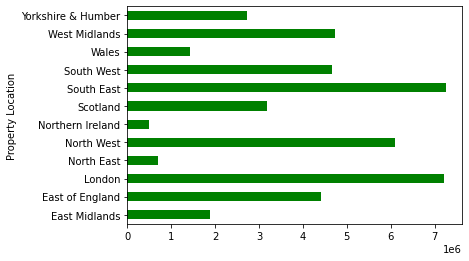

In [79]:
property_sums.plot.barh(color='green') 

The next step is to define a series of functions which return the output we want. In this case the total amount of interest paid over the life time of the loan and the total monthly loan repayment with a changing reverse interest rate and change in balance of principal payment and interest payment.

In [80]:
#Define a function which calculates the total interest paid over the lifetime of each loan.

def cumulative_interest(start_date,repayment_amount,months_period, loan_amount, initial_interest, final_interest, reversion_date):
    date = start_date
    delta = timedelta(days=30*int(months_period))
    outstanding_loan_amount = int(loan_amount)
    total_interest = 0
    while outstanding_loan_amount>0:
        interest_paid = initial_interest * outstanding_loan_amount
        total_interest += interest_paid
        outstanding_loan_amount -= repayment_amount
        date += delta
        print(date, outstanding_loan_amount, interest_paid)
    return(total_interest)

In [81]:
#Define a function which calculates the monthly payment with a fixed interest rate

def single_rate_payment(p,n,r):
  r = r /100.0
  rf = (1 + r)**n
  c = r*p*rf/(rf - 1)
  return c

#Define a function which calculates the monthly payment with a changing rate (reverse rate)

def monthly_payment(loan_amount,periods_to_today,original_rate_period,original_rate,reverse_rate):
  P = loan_amount
  N = periods_to_today
  M = original_rate_period
  r = original_rate / 100
  s = reverse_rate / 100
  ifr = (1 + r) ** M
  ifs = (1 + s) ** (N - M)
  C = r*P*ifr*ifs/(ifr*ifs - 1)
  return C

In [82]:
#call function and print total monthly repayment for a test loan.

monthly = monthly_payment(12000, 180, 60, 5.35, 4.30)
print(monthly)

642.1800808046846


In [87]:
#call function for cumulative interest over the loan's life time using a test loan.

time_in_string = "01-01-2005"
test_date = datetime.strptime(time_in_string, "%d-%m-%Y")
total_paid_interest = cumulative_interest(test_date, 642, 230, 12000, 0.053, 0.043, "2015-05-10")
print(total_paid_interest) 

2023-11-23 00:00:00 11358 636.0
2042-10-14 00:00:00 10716 601.9739999999999
2061-09-04 00:00:00 10074 567.948
2080-07-26 00:00:00 9432 533.922
2099-06-17 00:00:00 8790 499.89599999999996
2118-05-09 00:00:00 8148 465.87
2137-03-30 00:00:00 7506 431.844
2156-02-19 00:00:00 6864 397.818
2175-01-10 00:00:00 6222 363.792
2193-12-01 00:00:00 5580 329.76599999999996
2212-10-23 00:00:00 4938 295.74
2231-09-14 00:00:00 4296 261.714
2250-08-05 00:00:00 3654 227.688
2269-06-26 00:00:00 3012 193.662
2288-05-17 00:00:00 2370 159.636
2307-04-09 00:00:00 1728 125.61
2326-02-28 00:00:00 1086 91.584
2345-01-19 00:00:00 444 57.558
2363-12-11 00:00:00 -198 23.532
6265.554


In [84]:
total_loan_payment = (total_paid_interest + 12000)
print(total_loan_payment)

18265.554


The final stage is to take the functions and apply them to the data frame instead of having to input individual loan data as we have done so far.

In [35]:
loan_data['Monthly payment'] = loan_data.apply(monthly_payment('Original Loan', 'Loan To Today', 'Original Rate Period', 'Original Rate', 'Current Nominal Rate'), axis=1)

TypeError: unsupported operand type(s) for /: 'str' and 'int'